### Import Modules

In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import sys
sys.path.append('/Users/dominicbates/Documents/Github/statistical-analysis-templates/')
from useful_functions import marginals_hist, plot_all_marginals

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Create some fake data

In [2]:
data_size = 15

# Create three independant variables
np.random.seed(0)
f1 = np.random.randn(data_size)*3
f2 = np.random.randn(data_size)*2
f3 = np.random.randn(data_size)/2

# Sum linearly and add some noise
out = (2*f1) + (1*f2) + (-1*f3) + np.random.randn(data_size)

In [3]:
df = pd.DataFrame({
    'feature_1':f1,
    'feature_2':f2,
    'feature_3':f3,
    'target':out
})

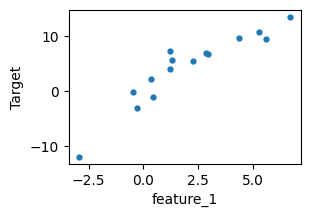

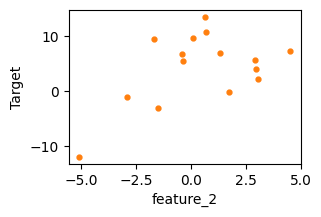

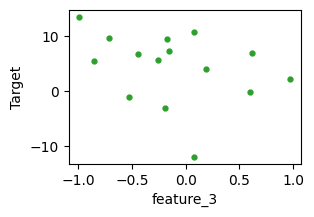

In [4]:
count = 0
for feature in [f for f in list(df) if f!='target']:
    plt.figure(figsize=(3,2))
    plt.plot(df[feature], df['target'], f'C{count}.', markersize=7)
    plt.ylabel('Target')
    plt.xlabel(feature)
    count+=1

In [5]:
df.head(5)

,feature_1,feature_2,feature_3,target
0,5.292157,0.667349,0.077474,10.736115
1,1.200472,2.988158,0.189081,3.947225
2,2.936214,-0.410317,-0.443893,6.683495
3,6.722680,0.626135,-0.990398,13.447995
4,5.602674,-1.708191,-0.173956,9.458372


In [6]:
# Define features and target
features = ['feature_1', 'feature_2', 'feature_3']
target = 'target'

### Fit Bayesian linear model

In [7]:
# Define data
X = df[features]
y = df[target]

# Define model
with pm.Model() as model:
    # Priors for coefficients and intercept
    intercept = pm.Normal('intercept', mu=0, sigma=10) # Prior on intercept
    betas = pm.Normal('betas', mu=0, sigma=10, shape=len(features)) # Priors on betas
    sigma = pm.HalfNormal('sigma', sigma=10)
    
    # Linear model
    mu = intercept + pm.math.dot(X, betas)
    
    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)
    
    # Sample from the posterior
    trace = pm.sample(2000, tune=1000)#, return_inferencedata=False)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas, sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


### Plot summary

In [8]:
az.summary(trace, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,-0.38,0.30,-0.96,0.19,0.00,0.00,5216.22,4627.20,1.0
betas[0],2.01,0.11,1.81,2.23,0.00,0.00,4307.41,4505.62,1.0
betas[1],0.99,0.11,0.79,1.20,0.00,0.00,5155.64,4224.37,1.0
betas[2],-1.08,0.53,-2.04,-0.02,0.01,0.01,5231.88,4948.81,1.0
sigma,0.88,0.22,0.53,1.27,0.00,0.00,4291.21,4115.25,1.0


### Trace summary

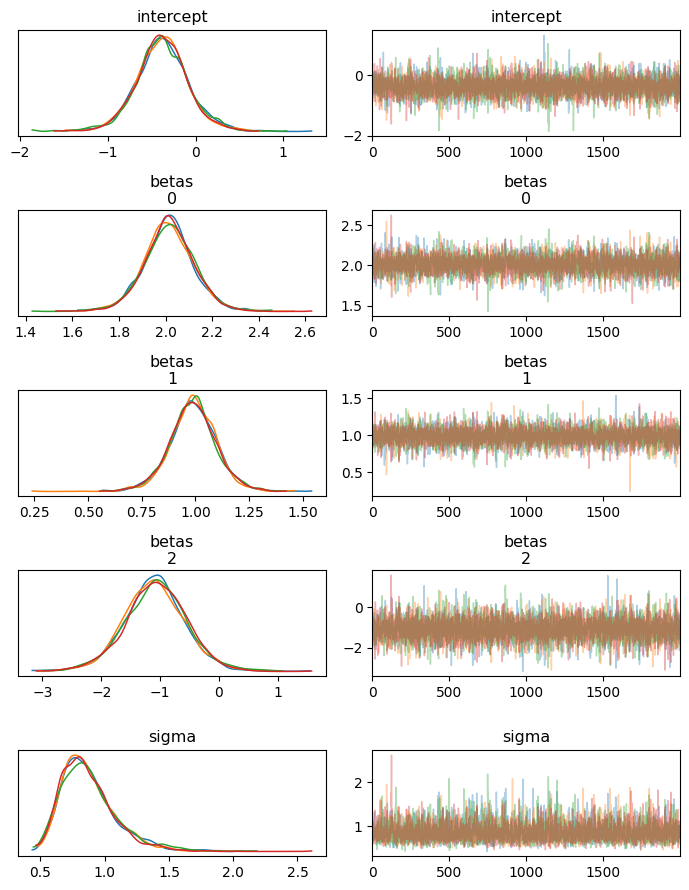

In [9]:
names = features + ["intercept", "sigma"]
pm.plot_trace(trace, figsize=(7,9), compact=False);
plt.tight_layout()

### Pair plot

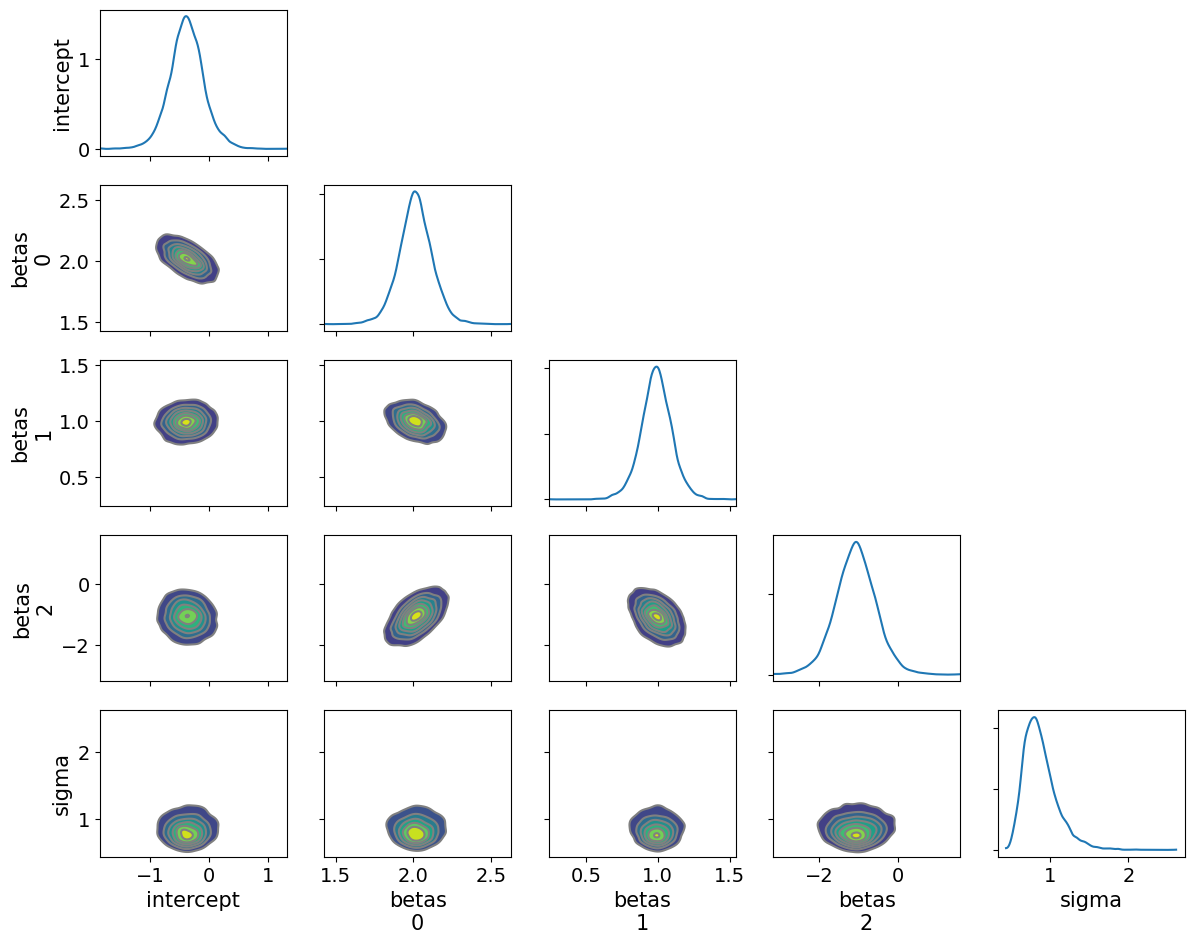

In [10]:
# Plot pair plot and marginals
az.plot_pair(trace, kind='kde', marginals=True, figsize=(14,11));


### Plot marginals distributions

In [17]:
# # Plot betas
# for n in range(len(features)):
#     vals = trace.posterior.betas.values[:,:,n].flatten()
#     marginals_hist(vals, features[n])

# # Plot intercept
# vals = trace.posterior.intercept.values.flatten()
# marginals_hist(vals, 'intercept', color='C1')

# # Plot sigma (noise)
# vals = trace.posterior.sigma.values.flatten()
# marginals_hist(vals, 'sigma', color='C2')

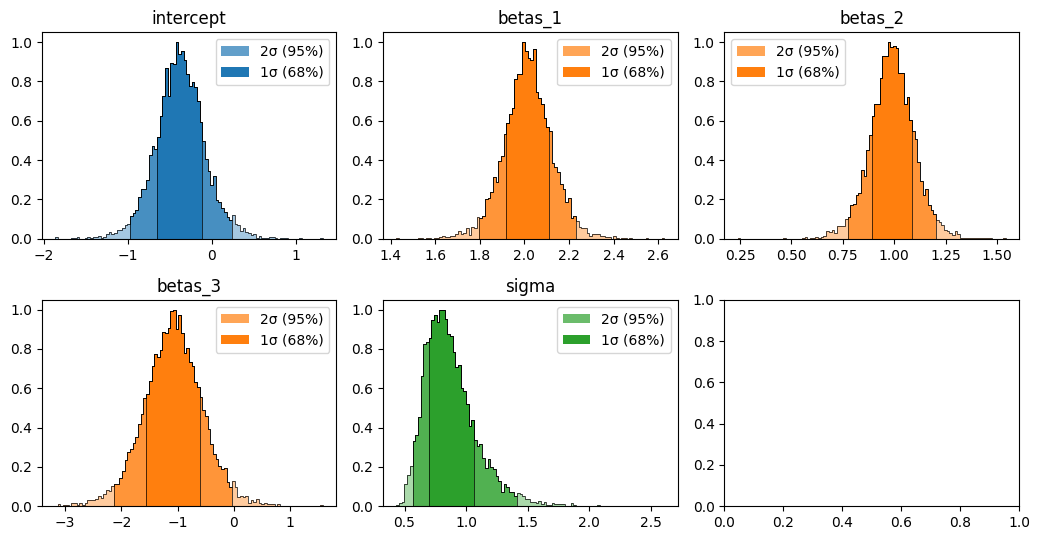

In [16]:
plot_all_marginals(trace, grid_shape = (2,3))

### Test some hypothesss

In [16]:
# Compute P(beta_1 > beta_2)
p_b2_gtr_b3 = np.mean(trace.posterior.betas.values[:,:,1] > trace.posterior.betas.values[:,:,2])

# # Compute P(ntercept > 0)
p_int_gtr_zero = np.mean(trace.posterior.intercept.values > 0)
p_b3_gtr_zero = np.mean(trace.posterior.betas.values[:,:,2] > 0)


In [18]:
print(f'Prob f2 > f3: {p_b2_gtr_b3:.3f}')
print(f'Prob f3 > 0: {p_b3_gtr_zero:.3f}')
print(f'Prob intercept > 0: {p_int_gtr_zero:.3f}')

Prob f2 > f3: 0.998
Prob f3 > 0: 0.026
Prob intercept > 0: 0.101


### Summary